**IMPORT REQUIRED LIBRARIES**

In [1]:
#importing necessary libraries

import os, warnings
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

#pytorch
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error #RMSE 

In [2]:
# select the device 
#seed to ensure some reproducibility 
seed=0
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    device=torch.device('cuda')
else:
    device=torch.device('cpu')

**INPUT DATA**

In [3]:

#training data
sales_data = pd.read_csv("/kaggle/input/dlcw3/sales_train.csv", parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                      'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

#test data
test_data = pd.read_csv("/kaggle/input/dlcw3/test.csv", dtype={'ID': 'int32', 'shop_id': 'int32', 
                                                  'item_id': 'int32'})


**EXPLORATORY DATA ANALYSIS**

In [4]:
print(f"Min date from train set: {sales_data['date'].min().date()}")
print(f"Max date from train set: {sales_data['date'].max().date()}")

Min date from train set: 2013-01-01
Max date from train set: 2015-12-10


In [5]:
print ('number of shops: ', sales_data['shop_id'].max())
print ('number of items: ', sales_data['item_id'].max())
num_month = sales_data['date_block_num'].max()
print ('number of month: ', num_month)

print('')
print ('size of train: ', sales_data.shape)

number of shops:  59
number of items:  22169
number of month:  33

size of train:  (2935849, 6)


In [6]:
#'Date' column changed from object datatype to datetime format
sales_data['date'] = pd.to_datetime(sales_data['date'],format = '%d.%m.%Y')

In [7]:
sales_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.000000,1
1,2013-03-01,0,25,2552,899.000000,1
2,2013-05-01,0,25,2552,899.000000,-1
3,2013-06-01,0,25,2554,1709.050049,1
4,2013-01-15,0,25,2555,1099.000000,1


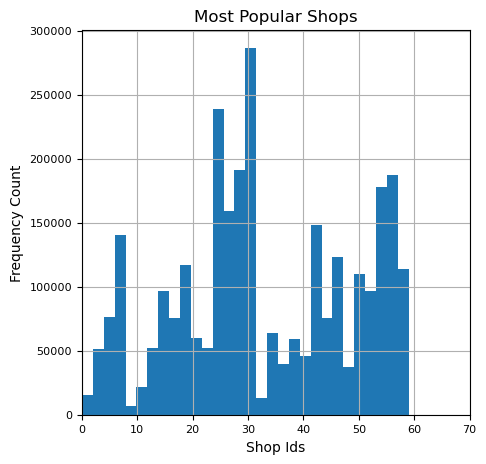

In [8]:
#Most Popular Shops 
sales_data['shop_id'].hist(figsize=(5, 5), bins=30, xlabelsize=8, ylabelsize=8)
plt.xlabel('Shop Ids')
plt.ylabel('Frequency Count')
plt.title('Most Popular Shops')
plt.xlim(left=0,right=70)
plt.show()

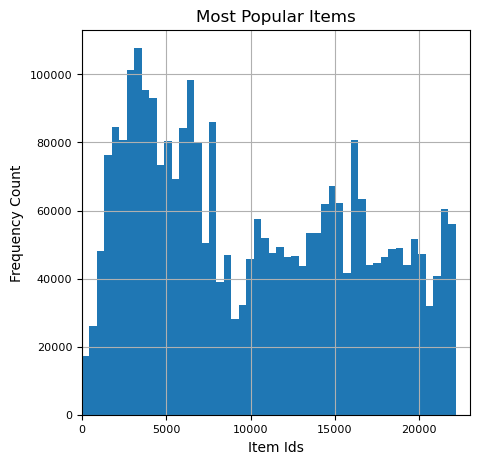

In [9]:
#Most Popular Items
sales_data['item_id'].hist(figsize=(5, 5), bins=50, xlabelsize=8, ylabelsize=8)
plt.xlabel('Item Ids')
plt.ylabel('Frequency Count')
plt.title('Most Popular Items')
plt.xlim(left=0,right=23000)
plt.show()

Sales analysis (year and monthwise)

In [10]:
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

yearly_data = sales_data[['date', 'date_block_num','item_cnt_day']]

#Making columns for year and month 
yearly_data['date']  = pd.to_datetime(yearly_data['date'], format='%d.%m.%Y')
yearly_data['month'] = yearly_data['date'].dt.month
yearly_data['year']  = yearly_data['date'].dt.year
yearly_data.drop(['date'], axis=1, inplace=True)

#Total number of items sold 
yearly_data = yearly_data.groupby('date_block_num', as_index=False)\
       .agg({'year':'first', 'month':'first', 'item_cnt_day':'sum'})\
       .rename(columns={'item_cnt_day':'monthwise_item_cnt'}, inplace=False)

print(yearly_data.head())

   date_block_num  year  month  monthwise_item_cnt
0               0  2013      2              131479
1               1  2013      2              128090
2               2  2013      3              147142
3               3  2013      4              107190
4               4  2013     10              106970


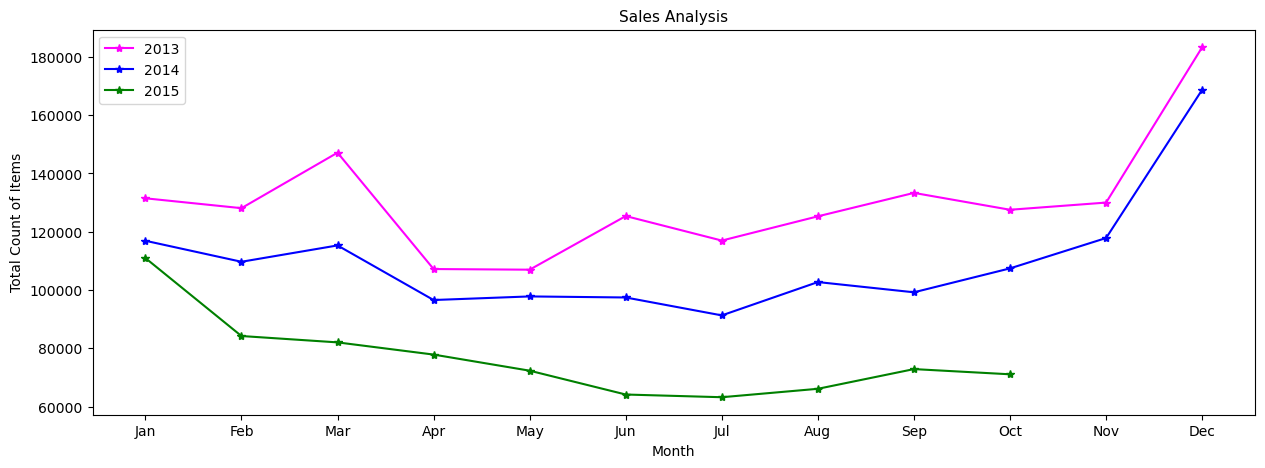

In [11]:
plt.figure(figsize=(15,5))
plt.plot(month_names, yearly_data[yearly_data.year==2013].monthwise_item_cnt, '-*', color='magenta',label='2013')
plt.plot(month_names, yearly_data[yearly_data.year==2014].monthwise_item_cnt, '-*', color='blue', label='2014')
plt.plot(month_names[:10], yearly_data[yearly_data.year==2015].monthwise_item_cnt, '-*', color='green',label='2015')
plt.xlabel('Month')
plt.ylabel('Total Count of Items')
plt.title('Sales Analysis', fontsize=11)
plt.legend(loc='upper left', fontsize=10)
plt.show()

In [12]:
shops_testdata = test_data['shop_id'].unique()
shops_itemdata = test_data['item_id'].unique()
reqdata = sales_data[sales_data['shop_id'].isin(shops_testdata )]
newdata = reqdata[reqdata['item_id'].isin(shops_itemdata)]

#Only columns required for visualisation
newdata = newdata[['date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day']]

newdata = newdata.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)
newdata = newdata.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
newdata.columns = ['date_block_num', 'shop_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']
newdata.fillna(0,inplace = True)

# Extract time based features.
newdata['year'] = newdata['date_block_num'].apply(lambda x: ((x//12) + 2013))
newdata['month'] = newdata['date_block_num'].apply(lambda x: (x % 12))

# Grouping data for EDA.
meansales_month = newdata.groupby(['month'], as_index=False)['item_cnt'].mean()

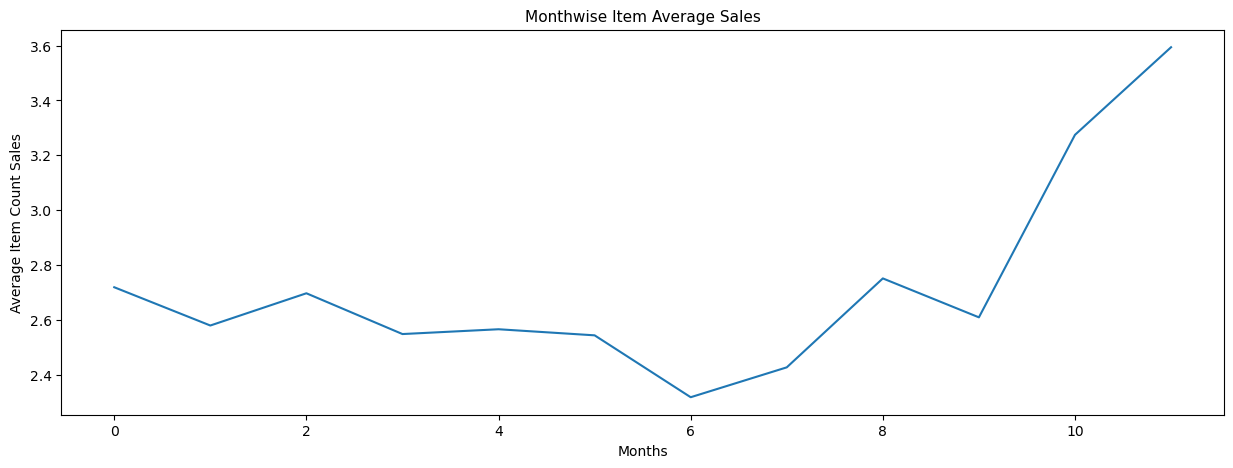

In [13]:
fig, axes = plt.subplots(figsize=(15,5))

# Plotting mean sales
axes.plot(meansales_month.month, meansales_month.item_cnt)

axes.set_xlabel('Months')
axes.set_ylabel('Average Item Count Sales')
axes.set_title('Monthwise Item Average Sales', fontsize=11)

plt.show()

In [14]:
#a pivot table 
#each row represents a sale of an item at a particular shop on a particular date 
#item_cnt_day column specifies the number of items sold on that month
dataset = sales_data.pivot_table(index = ['shop_id','item_id'],values = ['item_cnt_day'],columns = ['date_block_num'],fill_value = 0,aggfunc='sum')

In [15]:
dataset.reset_index(inplace = True)
dataset = pd.merge(test_data,dataset,on = ['item_id','shop_id'],how = 'left')

In [16]:
dataset.head()

,ID,shop_id,item_id,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# fill all NaN values with 0
dataset.fillna(0,inplace = True)
dataset.head()

,ID,shop_id,item_id,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)",...,"(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
#create the series of 12 months for each shop-item pair.

first_month = 20
last_month = 33
month_count = 12
data = []

#resulting dataframe will contain data for 12 months and label value (months 20 to 33) for each shop-item pair.
for index, row in dataset.iterrows():
    for month1 in range((last_month - (first_month + month_count)) + 1):
        series = [row['shop_id'], row['item_id']]
        for month2 in range(month_count + 1):
            series.append(row[month1 + first_month + month2])
        data.append(series)

columns = ['shop_id', 'item_id']
[columns.append(i) for i in range(month_count)]
columns.append('label')

data = pd.DataFrame(data, columns=columns)
data.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,8,9,10,11,label
0,5.0,5037.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0
1,5.0,5037.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0
2,5.0,5320.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.0,5320.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,5233.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0


In [19]:
data.drop(['shop_id','item_id'],inplace = True, axis = 1) 
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,label
0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0
1,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0


**TRAIN-TEST SPLIT**

In [20]:
from sklearn.model_selection import train_test_split
labels = data['label']
data.drop('label', axis=1, inplace=True)
train, test, Y_train, Y_test = train_test_split(data, labels.values, test_size=0.10, random_state=42)
train, valid, Y_train, Y_valid = train_test_split(train, Y_train, test_size=0.10, random_state=42)

In [21]:
print('Train data shape:', train.shape)
print('Validation data shape:',valid.shape)
print('Test data shape:',test.shape)

Train data shape: (346961, 12)
Validation data shape: (38552, 12)
Test data shape: (42835, 12)


In [22]:
X_train = train.values.reshape((train.shape[0], train.shape[1], 1))
X_valid = valid.values.reshape((valid.shape[0], valid.shape[1], 1))
X_test = test.values.reshape((test.shape[0], test.shape[1], 1))

print("Train set reshaped", X_train.shape)
print("Validation set reshaped", X_valid.shape)
print("Test set reshaped", X_test.shape)

Train set reshaped (346961, 12, 1)
Validation set reshaped (38552, 12, 1)
Test set reshaped (42835, 12, 1)


**MODEL 1 : LSTM**

In [27]:
# input shape dimensions

batch_size = 32
serie_size = X_train.shape[1]  # 12
n_features = X_train.shape[2]  # 1

Y_train = Y_train.reshape(-1, 1)
Y_valid = Y_valid.reshape(-1, 1)

# PyTorch DataLoader
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(Y_train))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# LSTM model
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=4, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=4, hidden_size=8, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(8, 1) #FC Layer
     
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]  # Extract last output from the sequence
        x = self.fc1(x)
        return x

In [38]:
lstm_model = LSTM().to(device)

epochs = 20

#optimizer and loss function
optimizer = optim.SGD(lstm_model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Train the LSTM model
for epoch in range(epochs):
    for (batch_X, batch_Y) in train_dataloader:
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device)

        # Forward pass
        predictions = lstm_model(batch_X)
        loss = criterion(predictions, batch_Y)
        
    # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
   
    # Calculate validation loss
    with torch.no_grad():
        val_X = torch.Tensor(X_valid).to(device)
        val_Y = torch.Tensor(Y_valid).to(device)
        val_predictions = lstm_model(val_X)
        val_loss = criterion(val_predictions, val_Y)
        print("Epoch [{}/{}], Loss: {:.4f}, Val Loss: {:.4f}".format(epoch+1, epochs, loss.item(), val_loss.item()))

Epoch [1/20], Loss: 0.0151, Val Loss: 7.3304
Epoch [2/20], Loss: 0.5767, Val Loss: 6.8437
Epoch [3/20], Loss: 0.6333, Val Loss: 6.6819
Epoch [4/20], Loss: 0.7479, Val Loss: 7.3541
Epoch [5/20], Loss: 0.1106, Val Loss: 7.7400
Epoch [6/20], Loss: 0.1293, Val Loss: 7.6455
Epoch [7/20], Loss: 0.1355, Val Loss: 7.4404
Epoch [8/20], Loss: 0.0211, Val Loss: 7.7153
Epoch [9/20], Loss: 0.2869, Val Loss: 7.0259
Epoch [10/20], Loss: 0.1685, Val Loss: 7.1300
Epoch [11/20], Loss: 0.0180, Val Loss: 7.8446
Epoch [12/20], Loss: 1.2966, Val Loss: 7.8423
Epoch [13/20], Loss: 0.2099, Val Loss: 7.7893
Epoch [14/20], Loss: 0.0803, Val Loss: 7.9206
Epoch [15/20], Loss: 0.3674, Val Loss: 7.7441
Epoch [16/20], Loss: 1.5953, Val Loss: 7.8310
Epoch [17/20], Loss: 0.0059, Val Loss: 7.8299
Epoch [18/20], Loss: 0.0803, Val Loss: 7.7780
Epoch [19/20], Loss: 5.2005, Val Loss: 7.7340
Epoch [20/20], Loss: 0.0757, Val Loss: 7.7229


PERFORMANCE OF LSTM MODEL

In [39]:
#RMSE for test data

test_loader = DataLoader(dataset=X_test, batch_size=1, shuffle=False) 

lstm_model.eval()
predictions = []
with torch.no_grad():
    for data in test_loader:
        inputs = data.float().to(device)  # move inputs to the GPU
        outputs = lstm_model(inputs)
        predictions.append(outputs.item())

predictions = np.array(predictions)

print('Test rmse:', np.sqrt(mean_squared_error(Y_test, predictions)))

Test rmse: 1.4465609850498995


**MODEL 2: AUTOENCODER with LSTM**

In [40]:
n_features = X_train.shape[2]  # 1

Y_train = Y_train.reshape(-1, 1)
Y_valid = Y_valid.reshape(-1, 1)

batch_size = 32

# Create PyTorch DataLoader
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(Y_train))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Autoencoder, self).__init__()
        
        #encoder
        self.encoder_lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.encoder_linear = nn.Linear(hidden_size, hidden_size)
        self.encoder_linear2 = nn.Linear(hidden_size, hidden_size)
        
        self.dropout = nn.Dropout(0.5) #dropout to prevent overfitting
        
        #decoder
        self.decoder_lstm = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)
        self.decoder_linear = nn.Linear(input_size, 1)
        self.decoder_linear2 = nn.Linear(1, 1)

    def forward(self, x):
        encoded, _ = self.encoder_lstm(x)
        encoded = self.encoder_linear(encoded[:, -1, :]) #Using last output from the sequence
        encoded = self.dropout(encoded)
        encoded = self.encoder_linear2(encoded)
     
        decoded, _ = self.decoder_lstm(encoded.unsqueeze(1))
        decoded = self.decoder_linear(decoded.squeeze(1))
        decoded = self.decoder_linear2(decoded)

        return decoded

# Instantiate the model
input_size = n_features
hidden_size = 8
num_layers = 2
model = Autoencoder(input_size, hidden_size, num_layers).to(device)

epochs = 20

#loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# input data to PyTorch tensors
input_data = X_train
Y_train = Y_train.reshape(-1, 1)
Y_valid  = Y_valid.reshape(-1, 1)

for epoch in range(epochs):
    for (batch_X, batch_Y) in train_dataloader:
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device)

        # Forward pass
        predictions = model(batch_X)
        loss = criterion(predictions, batch_Y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) #gradient clipping
        optimizer.step()
   
    # Calculate validation loss
    with torch.no_grad():
        val_X = torch.Tensor(X_valid).to(device)
        val_Y = torch.Tensor(Y_valid).to(device)
        val_predictions = model(val_X)
        val_loss = criterion(val_predictions, val_Y)
        print("Epoch [{}/{}], Loss: {:.4f}, Val Loss: {:.4f}".format(epoch+1, epochs, loss.item(), val_loss.item()))

Epoch [1/20], Loss: 0.0332, Val Loss: 7.6665
Epoch [2/20], Loss: 0.0651, Val Loss: 7.3441
Epoch [3/20], Loss: 0.0293, Val Loss: 7.1960
Epoch [4/20], Loss: 0.3320, Val Loss: 7.0575
Epoch [5/20], Loss: 0.1909, Val Loss: 6.9411
Epoch [6/20], Loss: 0.1533, Val Loss: 6.8396
Epoch [7/20], Loss: 0.2214, Val Loss: 6.6398
Epoch [8/20], Loss: 1.6802, Val Loss: 6.5184
Epoch [9/20], Loss: 0.0554, Val Loss: 6.4519
Epoch [10/20], Loss: 0.4846, Val Loss: 6.3852
Epoch [11/20], Loss: 0.2045, Val Loss: 6.2494
Epoch [12/20], Loss: 7.0361, Val Loss: 6.1714
Epoch [13/20], Loss: 0.2723, Val Loss: 6.1195
Epoch [14/20], Loss: 0.0928, Val Loss: 5.9993
Epoch [15/20], Loss: 0.3031, Val Loss: 6.5053
Epoch [16/20], Loss: 0.3062, Val Loss: 5.7070
Epoch [17/20], Loss: 0.2513, Val Loss: 5.7558
Epoch [18/20], Loss: 0.2370, Val Loss: 5.6943
Epoch [19/20], Loss: 3.8794, Val Loss: 5.7160
Epoch [20/20], Loss: 0.5340, Val Loss: 5.6771


PERFORMANCE OF AUTOENCODER MODEL

In [42]:
#RMSE for test data

test_loader = DataLoader(dataset=X_test, batch_size=1, shuffle=False)

model.eval()
predictions = []

with torch.no_grad():
    for data in test_loader:
        inputs = data.float().to(device)  # move inputs to the GPU
        outputs = model(inputs)
        predictions.append(outputs.item())

predictions = np.array(predictions)

print('Test rmse:', np.sqrt(mean_squared_error(Y_test, predictions)))

Test rmse: 1.1236310813700843
